In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler as std_scaler, OneHotEncoder as OHE
import pickle
import json
import matplotlib.pyplot as plt
import time
import gc

print("\nPackages imported successfully\n")


Packages imported successfully



In [2]:
# Handling jaguar movement data
class JaguarDataHandler():
    def __init__(self, directory = "./data/jaguar_data/"):
        self.directory = directory
        self.datasets = []
        self.training_Xs = []
        self.training_Ys = []
        
    def load_data(self, IDs = None):
        for id in IDs:
            name = "jag_"+str(id)+".csv"
            chunk = pd.read_csv(self.directory+name, sep = ",", decimal = ".", chunksize = 10000)
            data = pd.concat(chunk, ignore_index = True)
            del chunk
            self.datasets.append(
                data
            )
        return 0
    
    def data2training(self, variables, target_variables, target, step_ID, jaguar_ID = None,
                      del_IDs = True, del_original = False):
        
        if not target in target_variables:
            return -1
        if del_IDs and not step_ID:
            return -1
        
        for data in self.datasets:
            J = data.copy()
            X = J.filter(variables)
            Y = J.filter(target_variables)
            step_id = J[step_ID].unique()
            X_tf = []
            Y_tf = []
            for i in step_id:
                X_tmp = X[(X[step_ID] == i)]
                Y_tmp = Y[(Y[step_ID] == i)]
                Y_tmp = Y_tmp.filter([target])
                
                if del_IDs:
                    X_tmp.drop([jaguar_ID, step_ID], axis = 1, inplace = True)
                
                X_tf.append(X_tmp.to_numpy())
                Y_tf.append(Y_tmp.to_numpy().T)
            X_tf = tf.constant(X_tf)
            Y_tf = tf.constant(Y_tf)
            Y_tf = tf.reshape(Y_tf, [Y_tf.shape[0],Y_tf.shape[2]])
            self.training_Xs.append(X_tf)
            self.training_Ys.append(Y_tf)
        
        if del_original:
            self.datasets = []
            
        return 0

In [3]:
# Create data handler
data_handler = JaguarDataHandler()

# Importing Jaguars data
data_handler.load_data(IDs = [12,13,18,22,23,41,52,81,88,91,92,116,117])

variables = ['jaguar_ID', 'step_Num', 'step_length','hour','slope','topo','distdrain','distwater','tcover',
             'MaxNDVI', 'MedNDVI', 'landcover', 'humanfoot', 'popden', 'livestock', 'dist12', 'dist345', 'distanthropic',
             'distPA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun',
             'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'landC_anthropic', 'landC_natural',
             'landC_water', 'landC2_agro', 'landC2_nat_cover', 'landC2_nat_uncover', 'landC3_forest', 'landC3_grassland',
             'landC3_pasture_mosaic', 'landC3_shrubland', 'landC3_wetland_mangrove', 'suggested_x', 'suggested_y']
target_variables = ['jaguar_ID', 'step_Num', 'case_']
target = 'case_'
step_ID = 'step_Num'
jaguar_ID = 'jaguar_ID'

data_handler.data2training(variables,target_variables,target,step_ID,jaguar_ID)

c:\users\cliente\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

In [36]:
class noiseLayer(tf.keras.layers.Layer):

    def __init__(self,minVal,maxVal,seed = None):
        super(noiseLayer, self).__init__()
        self.minVal = minVal
        self.maxVal = maxVal
        self.seed = seed

    def call(self, inp):

        minVal = self.minVal
        maxVal  = self.maxVal
        seed = self.seed

        return inp + tf.random.uniform(tf.shape(inp), 
                                    minval = minVal,
                                    maxval = maxVal,
                                    seed = seed)

# Conditional Logistic Regression Model using Keras and Tensorflow APIs (with l1 and l2 regularization options)
class ConditionalLogisticRegression(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalLogisticRegression, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),)
    self.layer2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.noise(x)
    return x

# Conditional NN Models using Keras and Tensorflow APIs (with l1 and l2 regularization options)
class ConditionalNN1(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN1, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(10,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class ConditionalNN2(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN2, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(20,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class ConditionalNN11(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN11, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(10,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer2 = tf.keras.layers.Dense(10,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class ConditionalNN12(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN12, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(20,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer2 = tf.keras.layers.Dense(20,'tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class ConditionalNN21(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN21, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(10,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer2 = tf.keras.layers.Dense(10,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer3 = tf.keras.layers.Dense(10,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer4 = tf.keras.layers.Dense(10,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.layer3(x,training=training)
    x = self.layer4(x,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class ConditionalNN22(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(ConditionalNN22, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer2 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer3 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer4 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.layer3(x,training=training)
    x = self.layer4(x,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

class DeepConditionalNN(tf.keras.Model):
  def __init__(self, out_dim, l1 = 0, l2 = 0, name = 'model'):
    super(DeepConditionalNN, self).__init__(name=name)
    self.layer1 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer2 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer3 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer4 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer5 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer6 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layer7 = tf.keras.layers.Dense(20,'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL1 = tf.keras.layers.Dense(1,'linear',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))
    self.layerL2 = tf.keras.layers.Softmax(axis=-2)
    self.noise = noiseLayer(0.00001,0.00009)
  def call(self, input_tensor, training=False):
    x = self.layer1(input_tensor,training=training)
    x = self.layer2(x,training=training)
    x = self.layer3(x,training=training)
    x = self.layer4(x,training=training)
    x = self.layer5(x,training=training)
    x = self.layer6(x,training=training)
    x = self.layer7(x,training=training)
    x = self.layerL1(x,training=training)
    x = self.layerL2(x,training=training)
    x = self.noise(x)
    return x

In [5]:
# Create n_folds folds
n_folds = 7

x_train = tf.reverse(tf.concat(data_handler.training_Xs,axis=0),axis=[1])
y_train = tf.reverse(tf.concat(data_handler.training_Ys,axis=0),axis=[1])

indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

x_folds = tf.split(x_train,n_folds,axis=0)
y_folds = tf.split(y_train,n_folds,axis=0)

gc.collect()

60

In [37]:
all_models =    [[ConditionalLogisticRegression(out_dim = 201, l1 = 0, l2 = 0), [0.001,0,0,1024]],
                 [ConditionalNN2(out_dim = 201,    l1 = 0, l2 = 0), [0.005,0,0.00005,1024]],
                 [ConditionalLogisticRegression(out_dim = 201, l1 = 0, l2 = 0), [0.00001,0.005,0.005,512]],
                 [ConditionalNN11(out_dim = 201,   l1 = 0, l2 = 0), [0.00001,0.005,0.005,512]]
]

weights = []

# Test every model
for i in range(len(all_models)):
    
    learning_rate, l1, l2, mini_batch_size = all_models[i][1][0],all_models[i][1][1],all_models[i][1][2],all_models[i][1][3]

    L = 0

    x_train = tf.concat(x_folds[:L] + x_folds[L+1:], axis=0)
    x_test = tf.concat(x_folds[L],axis=0)

    y_train = tf.concat(y_folds[:L] + y_folds[L+1:], axis=0)
    y_test = y_folds[L]

    all_models[i][0].__init__(out_dim=201,l1=l1,l2=l2,name='model'+str(i))
    all_models[i][0].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = all_models[i][0].fit(x_train[:,:,0:40], y_train, epochs = 750,
              batch_size = mini_batch_size, shuffle = False, verbose = 0,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)])

    # Evaluate model on training and test sets
    loss_train, acc_train = all_models[i][0].evaluate(x_train[:,:,0:40],y_train,batch_size=x_train.shape[0])
    loss_test, acc_test = all_models[i][0].evaluate(x_test[:,:,0:40],y_test,batch_size=x_test.shape[0])

1/1 [==============================] - 0s 229ms/step - loss: 4.9222 - categorical_accuracy: 0.0562


KeyboardInterrupt: 

In [4]:
def plot_logit_weights(model = None, weights = None):
    if model is not None:
        plt.grid(zorder=0)
        x = np.array(['step_length','hour','slope','topo','distdrain','distwater','tcover',
        'MaxNDVI', 'MedNDVI', 'landcover', 'humanfoot', 'popden', 'livestock', 'dist12', 'dist345', 'distanthropic',
        'distPA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun',
        'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'landC_anthropic', 'landC_natural',
        'landC_water', 'landC2_agro', 'landC2_nat_cover', 'landC2_nat_uncover', 'landC3_forest', 'landC3_grassland',
        'landC3_pasture_mosaic', 'landC3_shrubland', 'landC3_wetland_mangrove'])
        y = np.array(model.get_weights()[0].T.tolist()[0])

        mask1 = y < 0
        mask2 = y >= 0

        plt.bar(x[mask1], y[mask1], color = 'red')
        plt.bar(x[mask2], y[mask2], color = 'blue')
        plt.xticks(rotation = 90)
    elif weights is not None:
        plt.grid(zorder=0)
        x = np.array(['step_length','hour','slope','topo','distdrain','distwater','tcover',
        'MaxNDVI', 'MedNDVI', 'landcover', 'humanfoot', 'popden', 'livestock', 'dist12', 'dist345', 'distanthropic',
        'distPA', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun',
        'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'landC_anthropic', 'landC_natural',
        'landC_water', 'landC2_agro', 'landC2_nat_cover', 'landC2_nat_uncover', 'landC3_forest', 'landC3_grassland',
        'landC3_pasture_mosaic', 'landC3_shrubland', 'landC3_wetland_mangrove'])
        y = np.array(weights)

        plt.bar(x, y)
        plt.xticks(rotation = 90)
    else:
        return

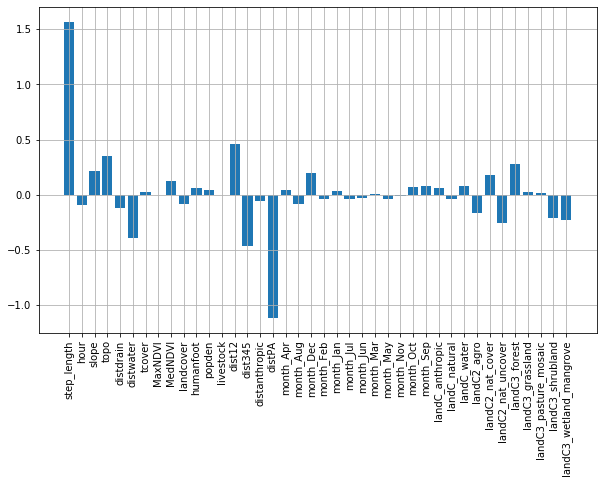

In [8]:
fig = plt.figure()
fig.set_size_inches(10.,6.)
plot_logit_weights(weights = [1.56712483e+00, -9.10944704e-02,  2.18394182e-01,  3.48886171e-01,
       -1.18171103e-01, -3.94138664e-01,  2.14385022e-02,  6.72100295e-04,
        1.21081205e-01, -8.53383365e-02,  6.17535178e-02,  3.92231448e-02,
       -2.62184488e-04,  4.61805557e-01, -4.65185110e-01, -5.51365144e-02,
       -1.12447660e+00,  4.54042533e-02, -8.46729529e-02,  1.97812350e-01,
       -4.12556870e-02,  2.98238423e-02, -4.29031796e-02, -3.36315036e-02,
        5.22485163e-03, -4.07065648e-02, -1.71008209e-02,  7.31715254e-02,
        8.11445777e-02,  5.83897382e-02, -3.62693763e-02,  7.68797360e-02,
       -1.65730279e-01,  1.77608447e-01, -2.61445555e-01,  2.74731486e-01,
        2.54228392e-02,  1.42553199e-02, -2.16173730e-01, -2.26203851e-01])
plt.savefig('clr_acc.png', dpi=300, bbox_inches='tight')
plt.show()

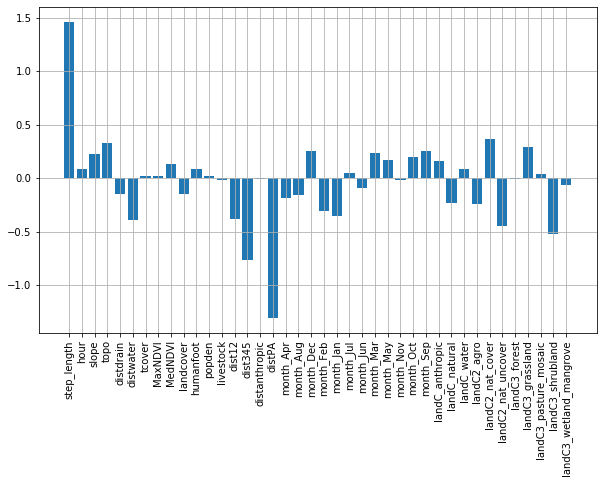

In [9]:
fig = plt.figure()
fig.set_size_inches(10.,6.)
plot_logit_weights(weights = [ 1.46115637,  0.08872556,  0.22644396,  0.32767394, -0.14923325,
       -0.38996604,  0.01882924,  0.0230976 ,  0.13378763, -0.14773519,
        0.08795583,  0.01536093, -0.01767525, -0.38707325, -0.76839131,
       -0.01073295, -1.31378305, -0.18655579, -0.15843545,  0.25271836,
       -0.31058297, -0.35640264,  0.04357056, -0.08937344,  0.23739251,
        0.16649823, -0.01398363,  0.20008893,  0.25795788,  0.16176695,
       -0.23214805,  0.08720637, -0.2440384 ,  0.36253321, -0.45266336,
       -0.0056031 ,  0.28997561,  0.03381855, -0.52509886, -0.06602078])
plt.savefig('clr_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Utility: measures distance between two 2D coordinates
def dist(a,b):
    return np.sqrt(np.square(a[0]-b[0]) + np.square(a[1]-b[1]))